## Let's import all the necessary libraries first

In [141]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import os
import datetime
import re
import seaborn as sns
import xgboost as xgb
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA

print(os.getcwd())
pd.options.display.max_columns = None

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Duratorre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Duratorre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Duratorre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\Duratorre\Desktop\DataScience_projects\Nanodegree\AirBnB Data


Let's read in the datasets

In [192]:
# read in the datasets
df_cal_sea = pd.read_csv('.\Seattle\calendar.csv')
#df_cal_sea.head(20)

df_cal_bos = pd.read_csv('.\Boston\calendar.csv')
df_cal_bos.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In the datasets, there is a __listing_id__ column that represent the houses, along with their __price__, and their __availability__ on a certain __date__.

Let's check the number of null values of price in the datasets

In [205]:
print(df_cal_sea.isna().mean(), "\n", df_cal_bos.isna().mean())

listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64 
  listing_id    0.000000
date          0.000000
available     0.000000
price         0.508716
dtype: float64


Null values are present only in the __price__ column of both datasets. It appears that null values only appears in those rows where availability is set to 'f', let's do a quick control.

In [206]:
df_cal_sea[(df_cal_sea.price.isna()) & (df_cal_sea.available == 't')]
df_cal_bos[(df_cal_bos.price.isna()) & (df_cal_bos.available == 't')]

,listing_id,date,available,price


As thought, there are no records with availability to true and null prices.

In order to obtain the average monthly price of the listing, we need to first remove all the _null_ values from the __price__ column, and then convert the __price__ column into _floats_. This means removing the _'$'_ and the comma from the column. We then use the __date__ column to create a new __month__ column, which contains the month of the respective date. Finally, we remove the __date__ and __available__ columns, as we don't need them anymore for the analysis. 

In [170]:
# drop rows with nan price and formatting data
def format_calendar(df):
    '''
    This function takes as input a dataframe originated by reading in the calendar.csv files, and formats it to make it
    ready to use for analysis on monthly prices, adding a column for the month, obtained by the date, and removing nans 
    from the price column
    
    Input:
    df - a pandas dataframe obtained by reading in the calendar.csv files
    
    Output:
    df_new - a pandas dataframe containing all the pertaining information for the analyis
    '''
        
    df_new = df.dropna(subset=['price']) # drop null values
    df_new.loc[:, 'price'] = df['price'].str.replace('$','')
    df_new.loc[:, 'price'] = df_new['price'].str.replace(',','').astype(float) # convert price to float
    df_new.loc[:, 'month'] = pd.to_datetime(df_new['date']).dt.month # create column month from column date
    df_new_clean = df_new.drop(columns=['date', 'available']) 

    return df_new_clean

df_cal_sea_form = format_calendar(df_cal_sea)
df_cal_bos_form = format_calendar(df_cal_bos)

df_cal_sea_form.head()

,listing_id,price,month
0,241032,85.0,1
1,241032,85.0,1
9,241032,85.0,1
10,241032,85.0,1
14,241032,85.0,1


Now the datasets are ready for the analysis. In order to obtain the average monthly prices of each listing, we take advantage of the _pandas_ _pivot_table_ method. With this method, we can display the average price, with months on the columns and the listings on the rows. With the methods _idxmax_ and _idxmin_, we can then calculate the month for which the average price is respectively the highest or the lowest. 

In [145]:
# obtain the months where prices are lower and higher for the two cities
def get_extremes(df, values, index, columns, aggfunc):
    '''
    This function creates a pivot table out of a dataframe and add columns "max" and "min" to the existing dataframe
    containing respectively the column labels with the highest and lowest values
    
    Input:
    df - a pandas dataframe that needs to be transformed into a pivot table
    values - a pandas dataframe column label that will be the aggregate value of the pivot
    index - a pandas dataframe column label that will be the rows of the pivot
    columns - a pandas dataframe column label that will be the columns of the pivot
    aggfunc - a function for aggregating the values
    
    Output:
    df_pivot - a pandas dataframe transformed into a pivot and with a "max" column for the maximum value among 
    existing columns
    '''
    
    # make a pivot out of the input df
    df_pivot = df.pivot_table(values=values, index=index, columns=columns, aggfunc=aggfunc).reset_index()
    
    # fill max and min with the indexes of the corresponding values
    df_pivot['max'] = df_pivot.drop(
        columns=df_pivot.columns[0]).idxmax(
        axis=1, skipna=True) # the index of the max value is also the corresponding month, drop the first column that contains listing id
    df_pivot['min'] = df_pivot.drop(
        columns=[df_pivot.columns[0], df_pivot.columns[-1]]).idxmin(axis=1, skipna=True) # drop also the last column as it contains the max
    df_pivot.columns.name = None
    
    # remove max e min for those rows with constant price throughout the year
    df_pivot.loc[(df_pivot['max']==df_pivot['min']),['max', 'min']] = np.nan
    
    for i in range(df_pivot.shape[0]):
        # remove max for those rows where the max appears more than once
        if sum(df_pivot.iloc[i, 1:-2] == df_pivot.iloc[i, 1:-2].max()) > 1:
            df_pivot.iloc[i, -2] = np.nan
        # remove min for those rows where the min appears more than once
        if sum(df_pivot.iloc[i, 1:-2] == df_pivot.iloc[i, 1:-2].min()) > 1:
            df_pivot.iloc[i, -1] = np.nan
        

    return df_pivot   

There aree some listings with constant price throughout the whole year, therefore in these cases we set the maximum and minimum to _null_ values. 
Other listing present a clear minimum or maximum, but not one of the other feature: for example a listing that has a maximum value in December and the rest of the year present the same price. In this case, we can't really determine a minimum, so we set the minimum to _null_. The same goes in the opposite case, i.e. no maximum.

In [146]:
import time
start = time.time()
df_cal_sea_ext = get_extremes(df_cal_sea_form, values='price', index='listing_id', columns='month', aggfunc=np.nanmean)
#df_cal_sea_ext.head()

end = time.time()
print(end - start)

14.578904867172241


In [147]:
df_cal_bos_ext = get_extremes(df_cal_bos_form, values='price', index='listing_id', columns='month', aggfunc=np.nanmean)
df_cal_bos_ext.head()
#df_cal_bos_ext.shape[0]

,listing_id,1,2,3,4,5,6,7,8,9,10,11,12,max,min
0,3353,32.612903,33.535714,35.354839,36.0,36.0,36.0,36.0,36.0,36.0,NaN,NaN,32.0,NaN,12.0
1,5506,145.000000,145.000000,145.000000,171.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,4.0,NaN
2,6695,195.000000,195.000000,195.000000,221.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,4.0,NaN
3,6976,65.000000,65.000000,65.000000,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,NaN,NaN
4,8792,154.000000,154.000000,154.000000,154.0,154.0,154.0,154.0,154.0,154.0,NaN,NaN,NaN,NaN,NaN


In [148]:
# get the best and worst month to rent an airbnb
best_sea = df_cal_sea_ext['max'].mode()
worst_sea = df_cal_sea_ext['min'].mode()

best_bos = df_cal_bos_ext['max'].mode()
worst_bos = df_cal_bos_ext['min'].mode()

print('The worst month to rent an airbnb in Seattle is {}, while the best month is {}'.format(best_sea.values[0], worst_sea.values[0]))
print('The worst month to rent an airbnb in Boston is {}, while the best month is {}'.format(best_bos.values[0], worst_bos.values[0]))

The worst month to rent an airbnb in Seattle is 4.0, while the best month is 1.0
The worst month to rent an airbnb in Boston is 10.0, while the best month is 12.0


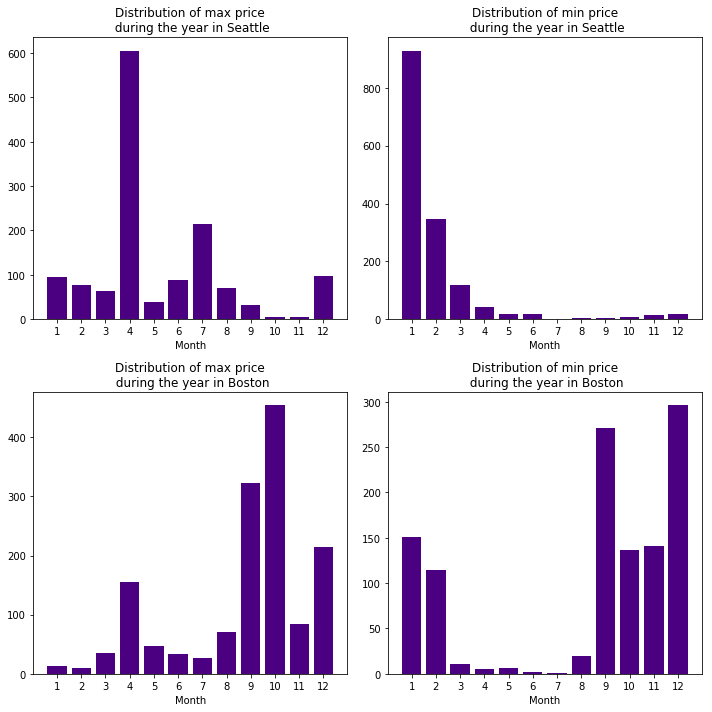

In [153]:
# plot density probabilities of max and min for Seattle and Boston
figure(figsize=(10,10))

values, counts = np.unique(df_cal_sea_ext['max'].dropna(), return_counts=True)
plt.subplot(2,2,1)
plt.bar(values, counts, align='center', color='Indigo')
plt.gca().set_xticks(values)
plt.xlabel('Month')
plt.title('Distribution of max price\n during the year in Seattle')
#plt.show()

values, counts = np.unique(df_cal_sea_ext['min'].dropna(), return_counts=True)
plt.subplot(2,2,2)
plt.bar(values, counts, align='center', color='Indigo')
plt.gca().set_xticks(values)
plt.xlabel('Month')
plt.title('Distribution of min price\n during the year in Seattle')
#plt.show()

values, counts = np.unique(df_cal_bos_ext['max'].dropna(), return_counts=True)
plt.subplot(2,2,3)
plt.bar(values, counts, align='center', color='Indigo')
plt.gca().set_xticks(values)
plt.xlabel('Month')
plt.title('Distribution of max price\n during the year in Boston')
#plt.show()

values, counts = np.unique(df_cal_bos_ext['min'].dropna(), return_counts=True)
plt.subplot(2,2,4)
plt.bar(values, counts, align='center', color='Indigo')
plt.gca().set_xticks(values)
plt.xlabel('Month')
plt.title('Distribution of min price\n during the year in Boston')

plt.tight_layout()
plt.show()
plt.savefig('MaxMinDistr.jpg', dpi=400)

#trovare modo di abbellire gli istogrammi

From thee graphs above, we can see that for Seattle the maximum and minimum prices have a well defined distribution, with peaks respectively for April and January. on the other side, the situation for Boston is not as easy to read, as the prices tend to be higher during September and October, albeit in the same months there are also a lot of listings with the lowest price (the number of listings with the lowest price is one third of the number of listings with the greatest price in October). 

In [ ]:
print((df_cal_sea_ext['min'] == 1).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 2).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 3).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 4).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 5).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 6).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 7).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 8).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 9).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 10).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 11).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 12).sum()/df_cal_sea_ext['min'].size,'\n')

print((df_cal_sea_ext['max'] == 1).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 2).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 3).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 4).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 5).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 6).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 7).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 8).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 9).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 10).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 11).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 12).sum()/df_cal_sea_ext['max'].size)


for i in range(1,13):
    print((df_cal_bos_ext['min'] == i).sum()/df_cal_bos_ext['min'].size)
print('\n')

for i in range(1,13):
    print((df_cal_bos_ext['max'] == i).sum()/df_cal_bos_ext['max'].size)
print('\n')


#months = 
#plt.plot()

## Let's analyze house prices

In [155]:
df_lis = pd.read_csv('.\Seattle\listings.csv')
df_lis.head()

df_lis_bos = pd.read_csv('.\Boston\listings.csv')
df_lis_bos.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

### Check of price vs other features

{'Sunset Hill', 'West Woodland', 'Mann', 'Loyal Heights', 'North Queen Anne', 'Wedgwood', 'Lawton Park', 'Briarcliff', 'Matthews Beach', 'West Queen Anne', 'East Queen Anne', 'Whittier Heights', 'Mid-Beacon Hill', 'Adams', 'Southeast Magnolia', 'Pike-Market'} {nan, 'Magnolia', 'Queen Anne', 'Capitol Hill', 'Pike Place Market', 'Licton Springs', 'Pike Market', 'Ballard', 'Wedgewood', 'The Junction', 'Mathews Beach'}
87 82


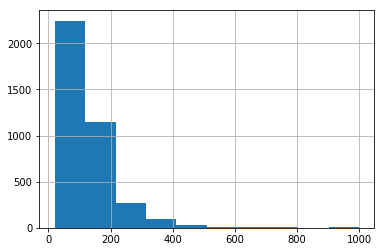

In [85]:
##DO NOT CONSIDER THIS CELL

#df_lis.room_type.unique()
print(set(df_lis.neighbourhood_cleansed.unique())-set(df_lis.neighbourhood.unique()),
set(df_lis.neighbourhood.unique())-set(df_lis.neighbourhood_cleansed.unique()))
#df_lis[df_lis['neighbourhood']=='Magnolia']
print(len(df_lis.neighbourhood_cleansed.unique()), len(df_lis.neighbourhood.unique()))
df_lis_bos.neighbourhood.unique()


df_lis.loc[:,'price'] = df_lis['price'].str.replace('$', '')
df_lis.loc[:,'price'] = df_lis['price'].str.replace(',', '').astype(float)
df_lis['price'].hist()

In [156]:
df_lis_compare = df_lis[['neighbourhood_group_cleansed', 'room_type', 'price']]
df_lis_compare.loc[:,'price'] = df_lis_compare['price'].str.replace('$', '').str.replace(',', '').astype(float)
#df_lis_compare.loc[:,'price'] = df_lis_compare['price'].str.replace(',', '').astype(float)

df_lis_bos_compare = df_lis_bos[['neighbourhood_cleansed', 'room_type', 'price']]
df_lis_bos_compare.loc[:,'price'] = df_lis_bos_compare['price'].str.replace('$', '').str.replace(',', '').astype(float)
#df_lis_bos_compare.loc[:,'price'] = df_lis_bos_compare['price'].str.replace(',', '').astype(float)

C:\Users\Duratorre\Anaconda\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Text(0, 0.5, 'Price')

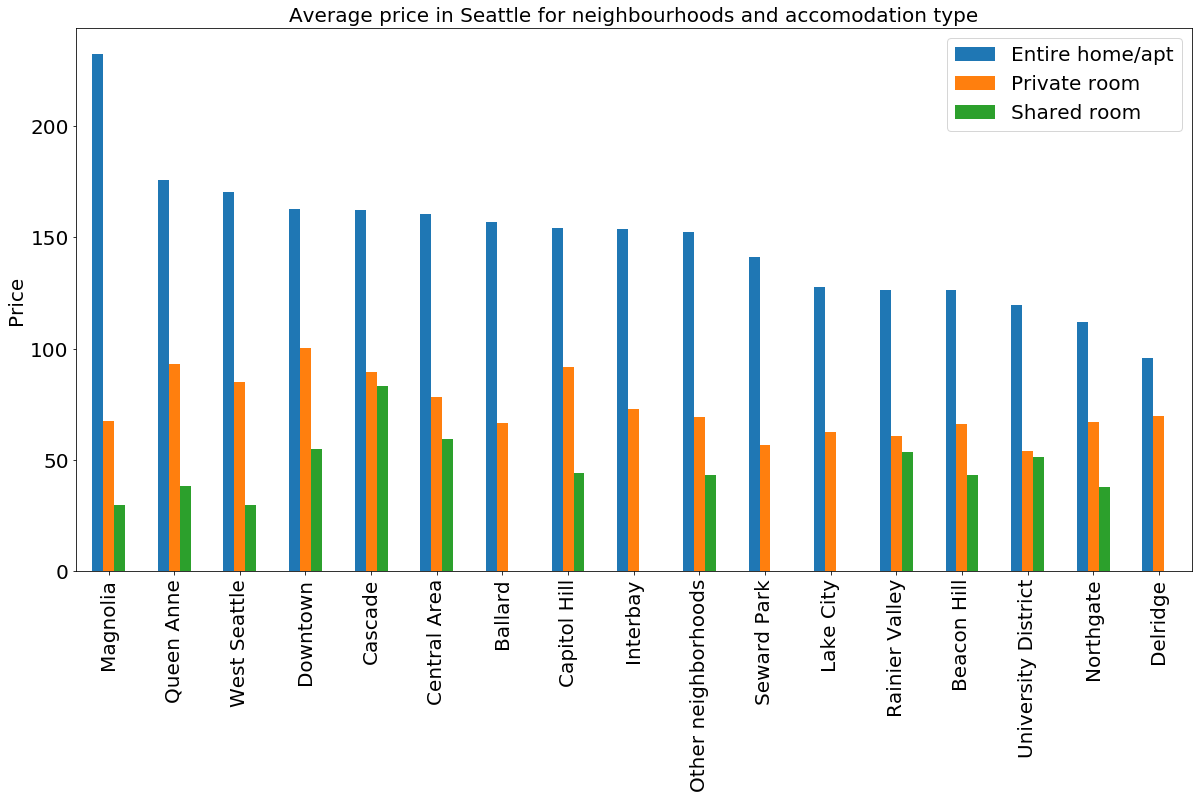

In [189]:
df_lis_plot = df_lis_compare.pivot_table(values='price', index='neighbourhood_group_cleansed', 
                                         columns='room_type', aggfunc=np.nanmean)
df_lis_plot.index.name = None 
df_lis_plot.sort_values(by='Entire home/apt', ascending=False).plot.bar(figsize=(20,10), legend=False, fontsize=20)#, 
                        #title='Average price in Seattle for neighbourhoods and accomodation type') ##Magnolia seems to have outliers

plt.title("Average price in Seattle for neighbourhoods and accomodation type",fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('Price', fontsize=20)
#df_lis[df_lis['neighbourhood_group_cleansed']=='Magnolia'].price.plot.box() ##3 max outliers

#df_lis_compare[(df_lis_compare['price'] > 400) & (df_lis_compare['neighbourhood_group_cleansed']=='Magnolia')]
#df_lis_compare[df_lis_compare['price'] > 900] ##outlier of 1000 is not for Magnolia

Text(0, 0.5, 'Price')

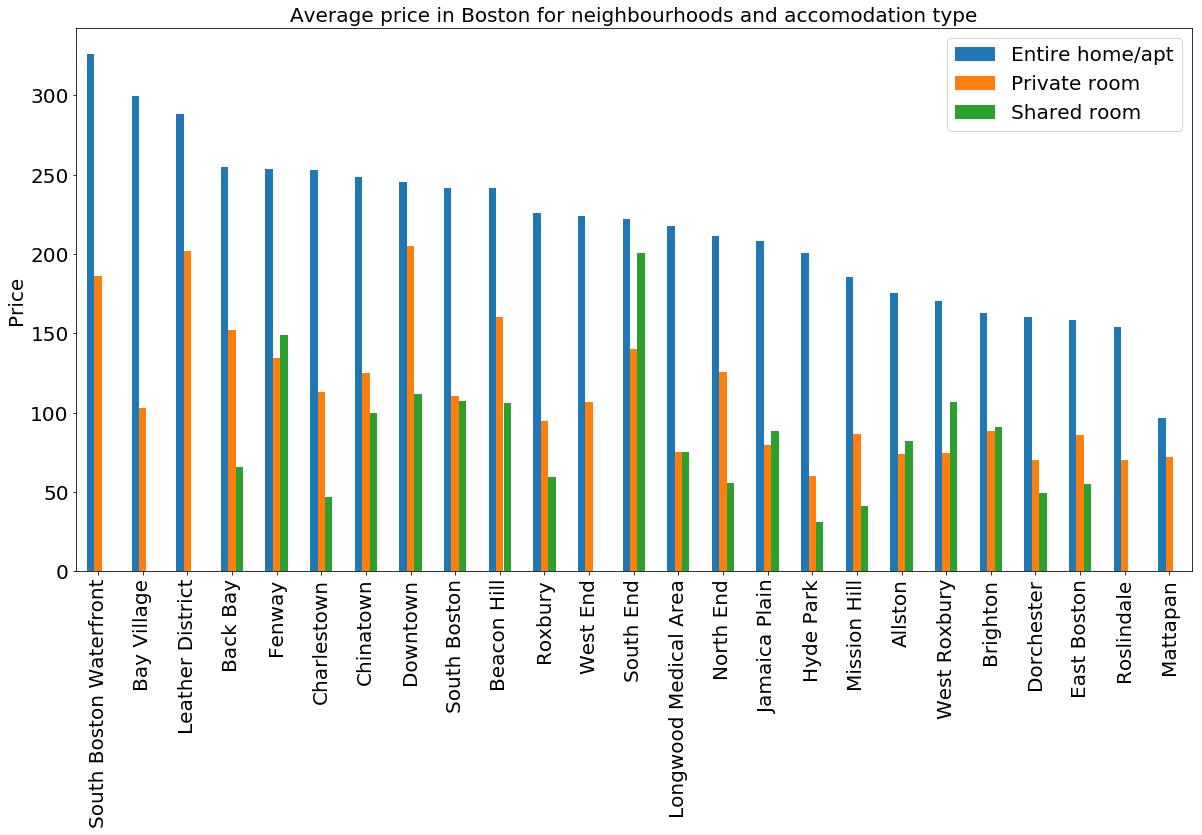

In [190]:
df_lis_bos_plot = df_lis_bos_compare.pivot_table(values='price', index='neighbourhood_cleansed', 
                                         columns='room_type', aggfunc=np.nanmean)

df_lis_bos_plot.index.name = None 
df_lis_bos_plot.sort_values(by='Entire home/apt', ascending=False).plot.bar(figsize=(20,10), fontsize=20, 
                            title='Average price in Boston for neighbourhoods and accomodation type') ##Magnolia seems to have outliers

plt.title("Average price in Boston for neighbourhoods and accomodation type",fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('Price', fontsize=20)

## Check of rating vs other features -- doesn't seem relevant

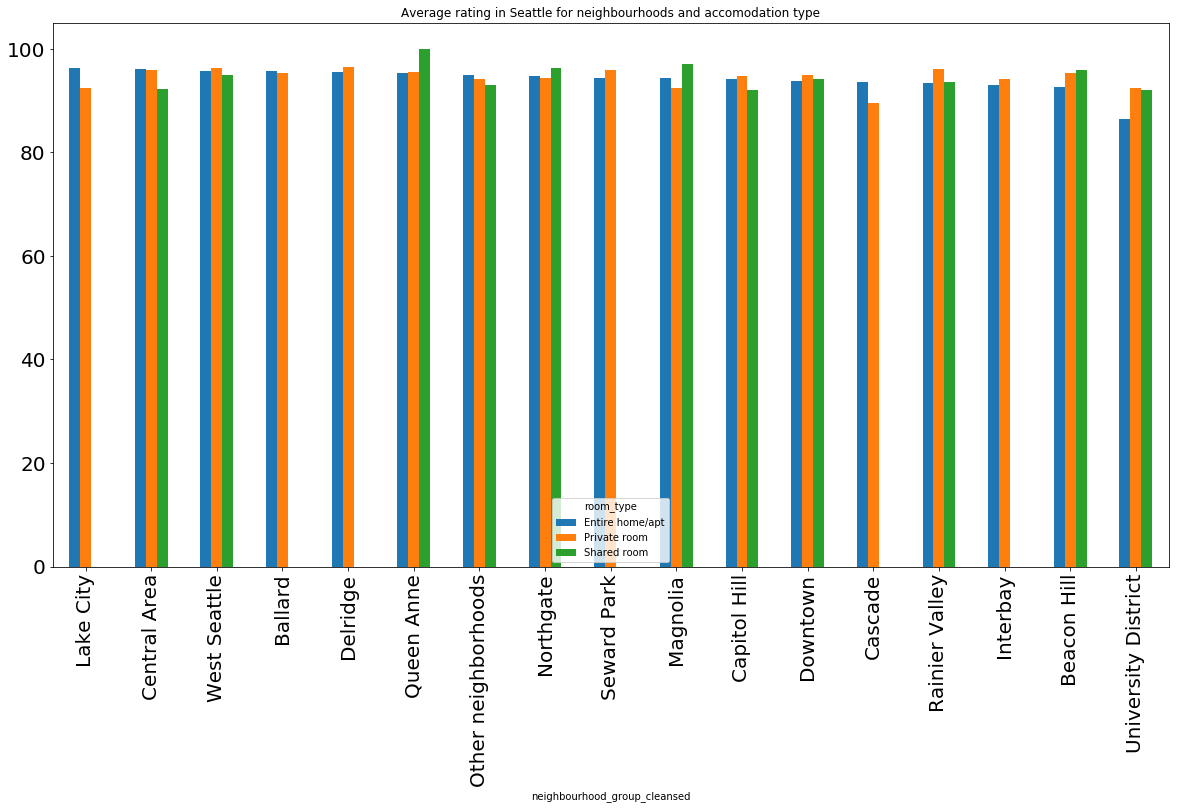

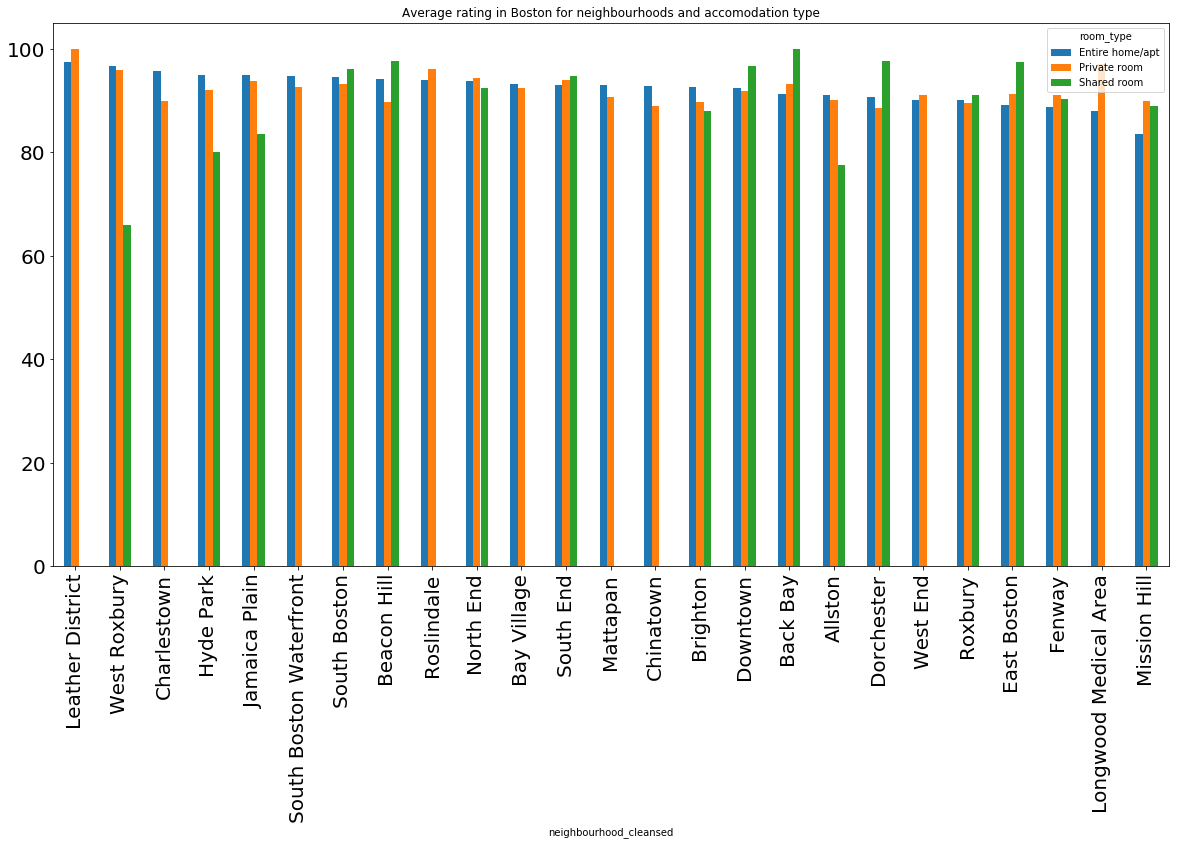

In [132]:
df_lis_compare = df_lis[['neighbourhood_group_cleansed', 'room_type', 'review_scores_rating']]
#df_lis_compare.loc[:,'review_scores_rating'] = df_lis_compare['review_scores_rating'].str.replace('$', '')
#df_lis_compare.loc[:,'review_scores_rating'] = df_lis_compare['review_scores_rating'].str.replace(',', '').astype(float)

df_lis_bos_compare = df_lis_bos[['neighbourhood_cleansed', 'room_type', 'review_scores_rating']]
#df_lis_bos_compare.loc[:,'review_scores_rating'] = df_lis_bos_compare['review_scores_rating'].str.replace('$', '')
#df_lis_bos_compare.loc[:,'review_scores_rating'] = df_lis_bos_compare['review_scores_rating'].str.replace(',', '').astype(float)

df_lis_plot = df_lis_compare.pivot_table(values='review_scores_rating', index='neighbourhood_group_cleansed', 
                                         columns='room_type', aggfunc=np.nanmean)

df_lis_plot.sort_values(by='Entire home/apt', ascending=False).plot.bar(figsize=(20,10), fontsize=20, 
                        title='Average rating in Seattle for neighbourhoods and accomodation type') ##Magnolia seems to have outliers

df_lis_bos_plot = df_lis_bos_compare.pivot_table(values='review_scores_rating', index='neighbourhood_cleansed', 
                                         columns='room_type', aggfunc=np.nanmean)

df_lis_bos_plot.sort_values(by='Entire home/apt', ascending=False).plot.bar(figsize=(20,10), fontsize=20, 
                            title='Average rating in Boston for neighbourhoods and accomodation type') ##Magnolia seems to have outliers

### Correlation of price vs ratings

C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


(array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.]),
 <a list of 11 Text yticklabel objects>)

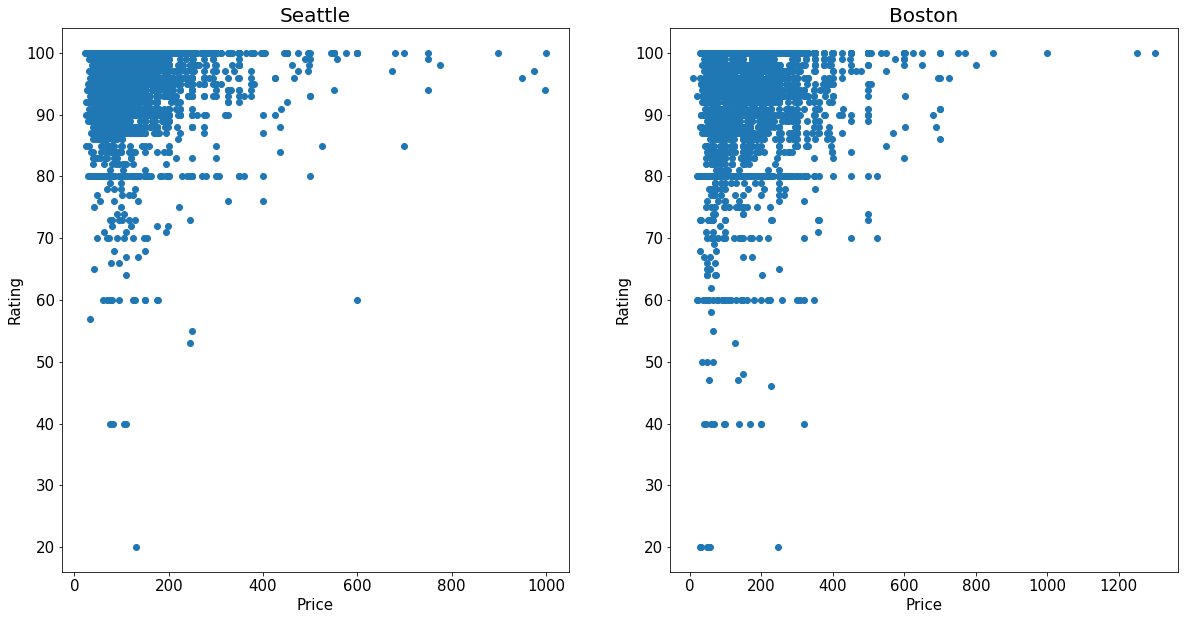

In [163]:
df_lis_scatter = df_lis[['price', 'review_scores_rating']]
df_lis_scatter.loc[:,'price'] = df_lis_scatter['price'].str.replace('$', '').str.replace(',', '').astype(float)
#df_lis_scatter.loc[:,'price'] = df_lis_scatter['price'].str.replace(',', '').astype(float)
#df_lis_scatter.loc[:,'review_scores_rating'] = df_lis_scatter['review_scores_rating'].str.replace('%', '').astype(float)
df_lis_scatter.dropna(inplace=True)

df_lis_bos_scatter = df_lis_bos[['price', 'review_scores_rating']]
df_lis_bos_scatter.loc[:,'price'] = df_lis_bos_scatter['price'].str.replace('$', '').str.replace(',', '').astype(float)
#df_lis_bos_scatter.loc[:,'price'] = df_lis_bos_scatter['price'].str.replace(',', '').astype(float)
#df_lis_scatter.loc[:,'review_scores_rating'] = df_lis_scatter['review_scores_rating'].str.replace('%', '').astype(float)
df_lis_bos_scatter.dropna(inplace=True)

figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(df_lis_scatter['price'], df_lis_scatter['review_scores_rating'])
plt.title('Seattle', fontsize=20)
plt.xlabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(1,2,2)
plt.scatter(df_lis_bos_scatter['price'], df_lis_bos_scatter['review_scores_rating'])
plt.title('Boston', fontsize=20)
plt.xlabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.yticks(fontsize=15)

## Prepare data for modelling price

In [101]:
# remove all columns with url
df_lis = df_lis.loc[:,~df_lis.columns.str.contains('url', case = False)]
df_lis.head()

,id,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,16708587,Jill,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,f,Queen Anne,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.629724,-122.369483,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV

In [102]:
# remove columns with unique values
unique_values = []
for col in list(df_lis.columns):
    if df_lis[col].unique().size==1:
        unique_values.append(col)
    
print(unique_values)

df_lis_no_unique = df_lis.drop(columns=unique_values)
#df_lis_no_unique.columns

['scrape_id', 'last_scraped', 'experiences_offered', 'market', 'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'license', 'jurisdiction_names']


In [103]:
# remove unnecessary columns
unnec_col = ['summary', 'space', 'description','name', 'host_id', 'host_name', 'host_since', 'host_location', 'host_about', 
             'host_neighbourhood', 'neighborhood_overview', 'notes', 'street', 'neighbourhood_cleansed', 
             'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'smart_location', 'latitude', 'longitude', 
             'weekly_price', 'monthly_price', 'calendar_updated', 'availability_30', 'availability_60', 'availability_90', 
             'availability_365', 'first_review', 'last_review', 'review_scores_accuracy', 'review_scores_cleanliness', 
             'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

df_lis_no_unn = df_lis_no_unique.drop(columns=unnec_col)
df_lis_no_unn.head()

print(df_lis_no_unn.columns)
print(df_lis_no_unn.isna().mean())

Index(['id', 'transit', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')
id                                  0.000000
transit                             0.244631
host_response_time                  0.136983
host_response_rate                  0.136983
host_

In [104]:
# dropping columns with no relevance for price, as well as columns with majority on nan values, like 
df_lis_new = df_lis_no_unn.drop(columns=['host_acceptance_rate', 'square_feet'])

# dropping rows with no ratings, as we can't perform correlation on those values
df_lis_new.dropna(axis=0, how='any', subset=['review_scores_rating'], inplace=True)

In [105]:
df_lis_new.head()
df_lis_new.isna().mean()
#df_lis9.shape

id                                  0.000000
transit                             0.203091
host_response_time                  0.098392
host_response_rate                  0.098392
host_is_superhost                   0.000000
host_listings_count                 0.000000
host_total_listings_count           0.000000
host_verifications                  0.000000
host_has_profile_pic                0.000000
host_identity_verified              0.000000
neighbourhood                       0.096184
is_location_exact                   0.000000
property_type                       0.000000
room_type                           0.000000
accommodates                        0.000000
bathrooms                           0.003784
bedrooms                            0.001892
beds                                0.000000
bed_type                            0.000000
amenities                           0.000000
price                               0.000000
security_deposit                    0.492274
cleaning_f

In [106]:
# taking rows where host_response_rate is not null
df_lis_clean = df_lis_new[~df_lis_new['host_response_rate'].isnull()]
df_lis_clean.isna().mean()
df_lis_clean.head()

,id,transit,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,NaN,within a few hours,96%,f,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$85.00,NaN,NaN,2,$5.00,1,365,207,95.0,f,moderate,f,f,2,4.07
1,953595,"Convenient bus stops are just down the block, ...",within an hour,98%,t,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",$150.00,$100.00,$40.00,1,$0.00,2,90,43,96.0,f,strict,t,t,6,1.48
2,3308979,A bus stop is just 2 blocks away. Easy bus a...,within a few hours,67%,f,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,Queen Anne,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$975.00,"$1,000.00",$300.00,10,$25.00,4,30,20,97.0,f,strict,f,f,2,1.15
4,278830,The nearest public transit bus (D Line) is 2 b...,within an hour,100%,f,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,Queen Anne,t,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",$450.00,$700.00,$125.00,6,$15.00,1,1125,38,92.0,f,strict,f,f,1,0.89
6,1909058,The bus goes through the lower Queen Anne neig...,within an hour,100%,t,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{""Wireless Internet"",""Free Parking on Premises...",$80.00,$150.00,NaN,1,$10.00,3,14,58,99.0,f,moderate,f,f,1,2.46


In [107]:
# casting columns to their proper data types

df_lis_clean.loc[:,'host_response_rate'] = df_lis_clean['host_response_rate'].str.replace('%', '').astype(float)
df_lis_clean.loc[:,'price'] = df_lis_clean['price'].str.replace('$', '').astype(float)
df_lis_clean.loc[:,'security_deposit'] = df_lis_clean['security_deposit'].str.replace('$', '').str.replace(',', '').astype(float)
#df_lis_clean.loc[:,'security_deposit'] = df_lis_clean['security_deposit'].str.replace(',', '').astype(float)
df_lis_clean.loc[:,'cleaning_fee'] = df_lis_clean['cleaning_fee'].str.replace('$', '').astype(float)
df_lis_clean.loc[:,'extra_people'] = df_lis_clean['extra_people'].str.replace('$', '').astype(float)

df_lis_clean.replace('t', 1, inplace=True)
df_lis_clean.replace('f', 0, inplace=True)

df_lis_clean['bedrooms'].fillna(0, inplace=True) # as there can be homes w/o bedrooms
df_lis_clean['bathrooms'].fillna(1, inplace=True) # all houses are entire building apartments or single rooms, there has to be a bathroom
df_lis_clean['security_deposit'].fillna(0, inplace=True)
df_lis_clean['cleaning_fee'].fillna(0, inplace=True)

df_lis_clean.head()

C:\Users\Duratorre\Anaconda\lib\site-packages\pandas\core\frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
C:\Users\Duratorre\Anaconda\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,id,transit,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,NaN,within a few hours,96.0,0,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,0.0,2,5.0,1,365,207,95.0,0,moderate,0,0,2,4.07
1,953595,"Convenient bus stops are just down the block, ...",within an hour,98.0,1,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,40.0,1,0.0,2,90,43,96.0,0,strict,1,1,6,1.48
2,3308979,A bus stop is just 2 blocks away. Easy bus a...,within a few hours,67.0,0,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",1,1,Queen Anne,1,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0,1000.0,300.0,10,25.0,4,30,20,97.0,0,strict,0,0,2,1.15
4,278830,The nearest public transit bus (D Line) is 2 b...,within an hour,100.0,0,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1,1,Queen Anne,1,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",450.0,700.0,125.0,6,15.0,1,1125,38,92.0,0,strict,0,0,1,0.89
6,1909058,The bus goes through the lower Queen Anne neig...,within an hour,100.0,1,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",1,1,Queen Anne,1,House,Private room,2,1.0,1.0,1.0,Real Bed,"{""Wireless Internet"",""Free Parking on Premises...",80.0,150.0,0.0,1,10.0,3,14,58,99.0,0,moderate,0,0,1,2.46


Check if there are nans left

In [108]:
df_lis_clean.isna().mean()

id                                  0.000000
transit                             0.198671
host_response_time                  0.000000
host_response_rate                  0.000000
host_is_superhost                   0.000000
host_listings_count                 0.000000
host_total_listings_count           0.000000
host_verifications                  0.000000
host_has_profile_pic                0.000000
host_identity_verified              0.000000
neighbourhood                       0.097936
is_location_exact                   0.000000
property_type                       0.000000
room_type                           0.000000
accommodates                        0.000000
bathrooms                           0.000000
bedrooms                            0.000000
beds                                0.000000
bed_type                            0.000000
amenities                           0.000000
price                               0.000000
security_deposit                    0.000000
cleaning_f

In [109]:
def extract_features(df, column_names):
    '''
    This function reproduces one hot encoding for those columns of a pandas dataframe that have a set or list of values 
    in each row
    
    Input:
    df - a pandas dataframe 
    column_names - a list of columns whose values are sets or lists
    
    Output:
    new_df - a dataframe with one hot encoding for the selected column
    '''
    
    # create a set of the distinct values contained in df[column_name]
    for column in column_names:
        item_set = set()
        for item in df[column]:
            item = re.sub(r"[^a-zA-Z0-9\,\/\-]", "", item)
            item = item.split(',')
            new_entry = set(item)
            item_set.update(new_entry)
    
    # remove any white spaces or None
        try:
            item_set.remove('')
        except:
            pass
        try:
            item_set.remove('None')
        except:
            pass

    # one hot encoding of df[column_name]
        for item in list(item_set):  #[:-1]:
            booleans = df[column].str.contains(item)
            new_col = [int(boolean) for boolean in booleans]
            new_col_name = '{}_{}'.format(column, item)
            df[new_col_name] = new_col
        
    # remove original columns from dataframe df
    new_df = df.drop(columns = column_names)
    
    return new_df

In [110]:
# Extracting features from categorical columns

df_lis_feat = extract_features(df_lis_clean, ['amenities', 'host_verifications'])

one_hot_columns = ['host_response_time', 'neighbourhood', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']
df_lis_ohe = pd.get_dummies(data = df_lis_feat, columns = one_hot_columns)  #, drop_first=True)
df_lis_ohe.head()



C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,id,transit,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,amenities_Shampoo,amenities_SafetyCard,amenities_Buzzer/WirelessIntercom,amenities_IndoorFireplace,amenities_PetsAllowed,amenities_LockonBedroomDoor,amenities_Essentials,amenities_ElevatorinBuilding,amenities_Family/KidFriendly,amenities_LaptopFriendlyWorkspace,amenities_Dryer,amenities_Cats,amenities_Doorman,amenities_WirelessInternet,amenities_Iron,amenities_Otherpets,amenities_Pool,amenities_Petsliveonthisproperty,amenities_WheelchairAccessible,amenities_SmokeDetector,amenities_FreeParkingonPremises,amenities_Breakfast,amenities_CableTV,amenities_HotTub,amenities_SuitableforEvents,amenities_CarbonMonoxideDetector,amenities_Heating,amenities_Dogs,amenities_Washer/Dryer,amenities_24-HourCheck-in,amenities_Hangers,amenities_Internet,amenities_Washer,amenities_HairDryer,amenities_Gym,amenities_AirConditioning,amenities_TV,amenities_SmokingAllowed,amenities_Kitchen,amenities_FirstAidKit,amenities_FireExtinguisher,host_verifications_weibo,host_verifications_linkedin,host_verifications_manualonline,host_verifications_google,host_verifications_kba,host_verifications_jumio,host_verifications_reviews,host_verifications_phone,host_verifications_amex,host_verifications_manualoffline,host_verifications_email,host_verifications_sentid,host_verifications_facebook,host_verifications_photographer,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_Alki,neighbourhood_Arbor Heights,neighbourhood_Atlantic,neighbourhood_Ballard,neighbourhood_Belltown,neighbourhood_Bitter Lake,neighbourhood_Brighton,neighbourhood_Broadview,neighbourhood_Broadway,neighbourhood_Bryant,neighbourhood_Capitol Hill,neighbourhood_Cedar Park,neighbourhood_Central Business District,neighbourhood_Columbia City,neighbourhood_Crown Hill,neighbourhood_Dunlap,neighbourhood_Eastlake,neighbourhood_Fauntleroy,neighbourhood_First Hill,neighbourhood_Fremont,neighbourhood_Gatewood,neighbourhood_Genesee,neighbourhood_Georgetown,neighbourhood_Green Lake,neighbourhood_Greenwood,neighbourhood_Haller Lake,neighbourhood_Harrison/Denny-Blaine,neighbourhood_High Point,neighbourhood_Highland Park,neighbourhood_Holly Park,neighbourhood_Industrial District,neighbourhood_Interbay,neighbourhood_International District,neighbourhood_Laurelhurst,neighbourhood_Leschi,neighbourhood_Licton Springs,neighbourhood_Lower Queen Anne,neighbourhood_Madison Park,neighbourhood_Madrona,neighbourhood_Magnolia,neighbourhood_Maple Leaf,neighbourhood_Mathews Beach,neighbourhood_Meadowbrook,neighbourhood_Minor,neighbourhood_Montlake,neighbourhood_Mount Baker,neighbourhood_North Admiral,neighbourhood_North Beach/Blue Ridge,neighbourhood_North Beacon Hill,neighbourhood_North Delridge,neighbourhood_Olympic Hills,neighbourhood_Phinney Ridge,neighbourhood_Pike Market,neighbourhood_Pike Place Market,neighbourhood_Pinehurst,neighbourhood_Pioneer Square,neighbourhood_Portage Bay,neighbourhood_Queen Anne,neighbourhood_Rainier Beach,neighbourhood_Ravenna,neighbourhood_Riverview,neighbourhood_Roosevelt,neighbourhood_Seaview,neighbourhood_Seward Park,neighbourhood_South Beacon Hill,neighbourhood_South Delridge,neighbourhood_South Lake Union,neighbourhood_South Park,neighbourhood_Stevens,neighbourhood_The Junction,neighbourhood_University District,neighbourhood_Victory Heights,neighbourhood_View Ridge,neighbourhood_Wallingford,neighbourhood_Wedgewood,neighbourhood_Westlake,neighbourhood_Windermere,neighbourhood_Yesler Terrace,property_type_Apartment,property_type_Bed & Breakfas

In [111]:
# One Hot Encoding for transportation

transport_means = ['Bus', 'Light Rail', 'Ferry', 'Heavy Rail', 'Train', 'Metro', 'NaN']

df_lis_ohe['transit'].fillna("NaN", inplace=True)

for mean in transport_means:  #[:-1]:
    booleans = df_lis_ohe['transit'].str.contains(mean, False)    #re.find(mean, 'hello', re.IGNORECASE)
    new_col = [int(boolean) for boolean in booleans]
    new_col_name = 'transit_{}'.format(mean)
    df_lis_ohe[new_col_name] = new_col

df_lis_ohe.drop(columns='transit', inplace=True)
df_lis_ohe.head()

,id,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,amenities_Shampoo,amenities_SafetyCard,amenities_Buzzer/WirelessIntercom,amenities_IndoorFireplace,amenities_PetsAllowed,amenities_LockonBedroomDoor,amenities_Essentials,amenities_ElevatorinBuilding,amenities_Family/KidFriendly,amenities_LaptopFriendlyWorkspace,amenities_Dryer,amenities_Cats,amenities_Doorman,amenities_WirelessInternet,amenities_Iron,amenities_Otherpets,amenities_Pool,amenities_Petsliveonthisproperty,amenities_WheelchairAccessible,amenities_SmokeDetector,amenities_FreeParkingonPremises,amenities_Breakfast,amenities_CableTV,amenities_HotTub,amenities_SuitableforEvents,amenities_CarbonMonoxideDetector,amenities_Heating,amenities_Dogs,amenities_Washer/Dryer,amenities_24-HourCheck-in,amenities_Hangers,amenities_Internet,amenities_Washer,amenities_HairDryer,amenities_Gym,amenities_AirConditioning,amenities_TV,amenities_SmokingAllowed,amenities_Kitchen,amenities_FirstAidKit,amenities_FireExtinguisher,host_verifications_weibo,host_verifications_linkedin,host_verifications_manualonline,host_verifications_google,host_verifications_kba,host_verifications_jumio,host_verifications_reviews,host_verifications_phone,host_verifications_amex,host_verifications_manualoffline,host_verifications_email,host_verifications_sentid,host_verifications_facebook,host_verifications_photographer,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_Alki,neighbourhood_Arbor Heights,neighbourhood_Atlantic,neighbourhood_Ballard,neighbourhood_Belltown,neighbourhood_Bitter Lake,neighbourhood_Brighton,neighbourhood_Broadview,neighbourhood_Broadway,neighbourhood_Bryant,neighbourhood_Capitol Hill,neighbourhood_Cedar Park,neighbourhood_Central Business District,neighbourhood_Columbia City,neighbourhood_Crown Hill,neighbourhood_Dunlap,neighbourhood_Eastlake,neighbourhood_Fauntleroy,neighbourhood_First Hill,neighbourhood_Fremont,neighbourhood_Gatewood,neighbourhood_Genesee,neighbourhood_Georgetown,neighbourhood_Green Lake,neighbourhood_Greenwood,neighbourhood_Haller Lake,neighbourhood_Harrison/Denny-Blaine,neighbourhood_High Point,neighbourhood_Highland Park,neighbourhood_Holly Park,neighbourhood_Industrial District,neighbourhood_Interbay,neighbourhood_International District,neighbourhood_Laurelhurst,neighbourhood_Leschi,neighbourhood_Licton Springs,neighbourhood_Lower Queen Anne,neighbourhood_Madison Park,neighbourhood_Madrona,neighbourhood_Magnolia,neighbourhood_Maple Leaf,neighbourhood_Mathews Beach,neighbourhood_Meadowbrook,neighbourhood_Minor,neighbourhood_Montlake,neighbourhood_Mount Baker,neighbourhood_North Admiral,neighbourhood_North Beach/Blue Ridge,neighbourhood_North Beacon Hill,neighbourhood_North Delridge,neighbourhood_Olympic Hills,neighbourhood_Phinney Ridge,neighbourhood_Pike Market,neighbourhood_Pike Place Market,neighbourhood_Pinehurst,neighbourhood_Pioneer Square,neighbourhood_Portage Bay,neighbourhood_Queen Anne,neighbourhood_Rainier Beach,neighbourhood_Ravenna,neighbourhood_Riverview,neighbourhood_Roosevelt,neighbourhood_Seaview,neighbourhood_Seward Park,neighbourhood_South Beacon Hill,neighbourhood_South Delridge,neighbourhood_South Lake Union,neighbourhood_South Park,neighbourhood_Stevens,neighbourhood_The Junction,neighbourhood_University District,neighbourhood_Victory Heights,neighbourhood_View Ridge,neighbourhood_Wallingford,neighbourhood_Wedgewood,neighbourhood_Westlake,neighbourhood_Windermere,neighbourhood_Yesler Terrace,property_type_Apartment,property_type_Bed & Breakfast,proper

In [126]:
df_lis_pred = df_lis_ohe.drop(columns='id')
df_lis_pred.head()
#df_lis_pred.shape

,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,amenities_Shampoo,amenities_SafetyCard,amenities_Buzzer/WirelessIntercom,amenities_IndoorFireplace,amenities_PetsAllowed,amenities_LockonBedroomDoor,amenities_Essentials,amenities_ElevatorinBuilding,amenities_Family/KidFriendly,amenities_LaptopFriendlyWorkspace,amenities_Dryer,amenities_Cats,amenities_Doorman,amenities_WirelessInternet,amenities_Iron,amenities_Otherpets,amenities_Pool,amenities_Petsliveonthisproperty,amenities_WheelchairAccessible,amenities_SmokeDetector,amenities_FreeParkingonPremises,amenities_Breakfast,amenities_CableTV,amenities_HotTub,amenities_SuitableforEvents,amenities_CarbonMonoxideDetector,amenities_Heating,amenities_Dogs,amenities_Washer/Dryer,amenities_24-HourCheck-in,amenities_Hangers,amenities_Internet,amenities_Washer,amenities_HairDryer,amenities_Gym,amenities_AirConditioning,amenities_TV,amenities_SmokingAllowed,amenities_Kitchen,amenities_FirstAidKit,amenities_FireExtinguisher,host_verifications_weibo,host_verifications_linkedin,host_verifications_manualonline,host_verifications_google,host_verifications_kba,host_verifications_jumio,host_verifications_reviews,host_verifications_phone,host_verifications_amex,host_verifications_manualoffline,host_verifications_email,host_verifications_sentid,host_verifications_facebook,host_verifications_photographer,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_Alki,neighbourhood_Arbor Heights,neighbourhood_Atlantic,neighbourhood_Ballard,neighbourhood_Belltown,neighbourhood_Bitter Lake,neighbourhood_Brighton,neighbourhood_Broadview,neighbourhood_Broadway,neighbourhood_Bryant,neighbourhood_Capitol Hill,neighbourhood_Cedar Park,neighbourhood_Central Business District,neighbourhood_Columbia City,neighbourhood_Crown Hill,neighbourhood_Dunlap,neighbourhood_Eastlake,neighbourhood_Fauntleroy,neighbourhood_First Hill,neighbourhood_Fremont,neighbourhood_Gatewood,neighbourhood_Genesee,neighbourhood_Georgetown,neighbourhood_Green Lake,neighbourhood_Greenwood,neighbourhood_Haller Lake,neighbourhood_Harrison/Denny-Blaine,neighbourhood_High Point,neighbourhood_Highland Park,neighbourhood_Holly Park,neighbourhood_Industrial District,neighbourhood_Interbay,neighbourhood_International District,neighbourhood_Laurelhurst,neighbourhood_Leschi,neighbourhood_Licton Springs,neighbourhood_Lower Queen Anne,neighbourhood_Madison Park,neighbourhood_Madrona,neighbourhood_Magnolia,neighbourhood_Maple Leaf,neighbourhood_Mathews Beach,neighbourhood_Meadowbrook,neighbourhood_Minor,neighbourhood_Montlake,neighbourhood_Mount Baker,neighbourhood_North Admiral,neighbourhood_North Beach/Blue Ridge,neighbourhood_North Beacon Hill,neighbourhood_North Delridge,neighbourhood_Olympic Hills,neighbourhood_Phinney Ridge,neighbourhood_Pike Market,neighbourhood_Pike Place Market,neighbourhood_Pinehurst,neighbourhood_Pioneer Square,neighbourhood_Portage Bay,neighbourhood_Queen Anne,neighbourhood_Rainier Beach,neighbourhood_Ravenna,neighbourhood_Riverview,neighbourhood_Roosevelt,neighbourhood_Seaview,neighbourhood_Seward Park,neighbourhood_South Beacon Hill,neighbourhood_South Delridge,neighbourhood_South Lake Union,neighbourhood_South Park,neighbourhood_Stevens,neighbourhood_The Junction,neighbourhood_University District,neighbourhood_Victory Heights,neighbourhood_View Ridge,neighbourhood_Wallingford,neighbourhood_Wedgewood,neighbourhood_Westlake,neighbourhood_Windermere,neighbourhood_Yesler Terrace,property_type_Apartment,property_type_Bed & Breakfast,property_

### Let's do all the steps above for the listings dataset of Boston

In [113]:
# remove all columns with url
lis_bos = df_lis_bos.loc[:,~df_lis_bos.columns.str.contains('url', case = False)]

# remove columns with unique values
unique_values = []
for col in list(lis_bos.columns):
    if lis_bos[col].unique().shape[0]==1:
        unique_values.append(col)
    
print(unique_values)

lis_bos_nounq = lis_bos.drop(columns=unique_values)

# remove unnecessary columns
unnec_col = ['summary', 'space', 'description','access', 'interaction', 'house_rules', 'name', 'host_id', 'host_name', 
             'host_since', 'host_location', 'host_about', 'host_neighbourhood', 'neighborhood_overview', 'notes', 'street', 
             'neighbourhood_cleansed', 'city', 'zipcode', 'smart_location', 'latitude', 'longitude', 'weekly_price', 
             'monthly_price', 'calendar_updated', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 
             'first_review', 'last_review', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
             'review_scores_communication', 'review_scores_location', 'review_scores_value']

lis_bos_nec = lis_bos_nounq.drop(columns=unnec_col)

print(lis_bos_nec.columns)
print(lis_bos_nec.isna().mean())

# dropping columns with no relevance for price, as well as columns with majority on nan values, like 
lis_bos_new = lis_bos_nec.drop(columns=['host_acceptance_rate', 'square_feet'])

# dropping rows with no ratings, as we can't perform correlation on those values
lis_bos_new.dropna(axis=0, how='any', subset=['review_scores_rating'], inplace=True)

# taking rows where host_response_rate is not null
lis_bos_clean = lis_bos_new[~lis_bos_new['host_response_rate'].isnull()]
print(lis_bos_clean.isna().mean())
lis_bos_clean.head()

lis_bos_clean.loc[:,'host_response_rate'] = lis_bos_clean['host_response_rate'].str.replace('%', '').astype(float)
lis_bos_clean.loc[:,'price'] = lis_bos_clean['price'].str.replace('$', '').str.replace(',', '').astype(float)
#lis_bos_clean.loc[:,'price'] = lis_bos_clean['price'].str.replace(',', '').astype(float)
lis_bos_clean.loc[:,'security_deposit'] = lis_bos_clean['security_deposit'].str.replace('$', '').str.replace(',', '').astype(float)
#lis_bos_clean.loc[:,'security_deposit'] = lis_bos_clean['security_deposit'].str.replace(',', '').astype(float)
lis_bos_clean.loc[:,'cleaning_fee'] = lis_bos_clean['cleaning_fee'].str.replace('$', '').astype(float)
lis_bos_clean.loc[:,'extra_people'] = lis_bos_clean['extra_people'].str.replace('$', '').astype(float)

lis_bos_clean.replace('t', 1, inplace=True)
lis_bos_clean.replace('f', 0, inplace=True)

lis_bos_clean['bedrooms'].fillna(0, inplace=True) # as there can be homes w/o bedrooms
lis_bos_clean['bathrooms'].fillna(1, inplace=True) # all houses are entire building apartments or single rooms, there has to be a bathroom
lis_bos_clean['security_deposit'].fillna(0, inplace=True)
lis_bos_clean['cleaning_fee'].fillna(0, inplace=True)
lis_bos_clean['beds'].fillna(1, inplace=True)

print(lis_bos_clean.isna().mean())

# Extracting features from categorical columns

bos_lis_feat = extract_features(lis_bos_clean, ['amenities', 'host_verifications'])

one_hot_columns = ['host_response_time', 'neighbourhood', 'property_type', 'room_type', 'bed_type', 'cancellation_policy', 'market']
bos_lis_ohe = pd.get_dummies(data = bos_lis_feat, columns = one_hot_columns)  #, drop_first=True)
bos_lis_ohe.head()

# One Hot Encoding for transportation

transport_means = ['Bus', 'Light Rail', 'Ferry', 'Heavy Rail', 'Train', 'Metro', 'NaN']

bos_lis_ohe['transit'].fillna("NaN", inplace=True)

for mean in transport_means:  #[:-1]:
    booleans = bos_lis_ohe['transit'].str.contains(mean, False)    #re.find(mean, 'hello', re.IGNORECASE)
    new_col = [int(boolean) for boolean in booleans]
    new_col_name = 'transit_{}'.format(mean)
    bos_lis_ohe[new_col_name] = new_col

bos_lis_ohe.drop(columns='transit', inplace=True)
bos_lis_ohe.head()

bos_lis_pred = bos_lis_ohe.drop(columns='id')
bos_lis_pred.head()
bos_lis_pred.isna().mean()

['scrape_id', 'last_scraped', 'experiences_offered', 'neighbourhood_group_cleansed', 'state', 'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'license', 'jurisdiction_names']
Index(['id', 'transit', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'market', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'square_feet', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',


C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


host_response_rate                                0.0
host_is_superhost                                 0.0
host_listings_count                               0.0
host_total_listings_count                         0.0
host_has_profile_pic                              0.0
host_identity_verified                            0.0
is_location_exact                                 0.0
accommodates                                      0.0
bathrooms                                         0.0
bedrooms                                          0.0
beds                                              0.0
price                                             0.0
security_deposit                                  0.0
cleaning_fee                                      0.0
guests_included                                   0.0
extra_people                                      0.0
minimum_nights                                    0.0
maximum_nights                                    0.0
number_of_reviews           

In [114]:
corr = df_lis_pred.corr()
#corr
corr.unstack()['price'].dropna().sort_values(ascending=False)

#fig, ax = plt.subplots(figsize=(40,40))         # Sample figsize in inches
#sns.heatmap(corr, ax=ax)

price                                    1.000000
accommodates                             0.668152
bedrooms                                 0.632544
cleaning_fee                             0.613956
beds                                     0.601474
bathrooms                                0.513543
room_type_Entire home/apt                0.452525
guests_included                          0.438377
security_deposit                         0.369866
cancellation_policy_strict               0.255363
amenities_TV                             0.237637
extra_people                             0.160228
amenities_Kitchen                        0.146008
amenities_Doorman                        0.136536
amenities_Gym                            0.131360
amenities_Washer                         0.130588
amenities_Pool                           0.126298
bed_type_Real Bed                        0.126107
neighbourhood_Belltown                   0.122702
amenities_Dryer                          0.114039


## Let's predict house prices

In [115]:
# linear regression
X = df_lis_pred.drop(columns='price')
y = df_lis_pred.price

#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#fit the model and obtain pred response
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
y_pred = lm_model.predict(X_test)
#y_train_preds = lm_model.predict(X_train)

#append the r2 value from the test set
r2_score(y_test, y_pred)
#r2_scores_test.append(r2_score(y_test, y_test_preds))
#r2_scores_train.append(r2_score(y_train, y_train_preds))
#results[str(cutoff)] = r2_score(y_test, y_test_preds)

0.5975665710484956

In [116]:
# logisitc regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

r2_score(y_test, y_pred_log)

C:\Users\Duratorre\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Duratorre\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Duratorre\Anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.24194504706196518

In [117]:
# using support vector machines
regr = svm.SVR()
regr.fit(X_train, y_train)

y_pred_svm = regr.predict(X_test)
r2_score(y_test, y_pred_svm)

C:\Users\Duratorre\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


-0.03457729700479484

In [122]:
# using random forest regressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

y_pred_rfr = rfr.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred_rfr)), r2_score(y_test, y_pred_rfr))

45.95126374606186 0.6859206579649966


In [123]:
# using xgboost
#!conda install -c conda-forge xgboost --yes
#!conda install -c anaconda py-xgboost

xgb_reg = xgb.XGBRegressor(
    n_estimators=200,
    reg_lambda=1,
    gamma=0,
    max_depth=3,
    random_state=42
)

xgb_reg.fit(X_train, y_train)

#pd.DataFrame(xgb_reg.feature_importances_.reshape(1, -1), columns=df_lis9.columns)

y_pred_xgb = xgb_reg.predict(X_test)

print(math.sqrt(mean_squared_error(y_test, y_pred_xgb)), r2_score(y_test, y_pred_xgb))

C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:56:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
44.14736539538151 0.710096115245241


In [124]:
X = bos_lis_pred.drop(columns='price')
y = bos_lis_pred.price

#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# using random forest regressor
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)

y_pred_rfr = rfr.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred_rfr)),r2_score(y_test, y_pred_rfr))

         
# using xgboost
#!conda install -c conda-forge xgboost --yes
#!conda install -c anaconda py-xgboost

xgb_reg = xgb.XGBRegressor(
    n_estimators=200,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

xgb_reg.fit(X_train, y_train)

#pd.DataFrame(xgb_reg.feature_importances_.reshape(1, -1), columns=df_lis9.columns)

y_pred_xgb = xgb_reg.predict(X_test)

print(math.sqrt(mean_squared_error(y_test, y_pred_xgb)), r2_score(y_test, y_pred_xgb))

60.01396244560213 0.6924624398585013
[23:57:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


59.72985756354582 0.6953673009234314


## Testing PCA

In [140]:
X = df_lis_pred.drop(columns='price')
y = df_lis_pred.price

results = []

for i in range(10,192):

    pca = PCA(n_components=i, random_state=42)
    pca.fit(X)
    X_p = pca.transform(X)

    #split the data into train and test
    X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(X_p, y, test_size=0.3, random_state=42)

    # using random forest regressor
    rfr = RandomForestRegressor(n_estimators=100, random_state=42)
    rfr.fit(X_p_train, y_p_train)

    y_p_pred_rfr = rfr.predict(X_p_test)
    results.append([math.sqrt(mean_squared_error(y_p_test, y_p_pred_rfr)),r2_score(y_p_test, y_p_pred_rfr)])
                    
results
#print(math.sqrt(mean_squared_error(y_p_test, y_p_pred_rfr)),r2_score(y_p_test, y_p_pred_rfr))

[[62.08357080006524, 0.4266790278996129],
 [52.96199785050614, 0.5827722637272057],
 [53.00247930934046, 0.5821342046267144],
 [51.499811095677266, 0.6054920813337712],
 [51.61244550270052, 0.6037645504455694],
 [51.44173355181424, 0.606381371264552],
 [51.71262478580798, 0.6022248789069675],
 [51.53329670786083, 0.6049788897851534],
 [52.11936221292925, 0.5959429971856962],
 [52.24591580049265, 0.5939783935278178],
 [52.02015777483201, 0.5974797043852331],
 [51.78236433552601, 0.6011512778879186],
 [51.69295591076739, 0.6025274085618046],
 [51.49346031531339, 0.6055893740658895],
 [51.24733099423456, 0.6093507843959093],
 [50.80212927208946, 0.6161086881235559],
 [51.01583243782276, 0.6128721568543889],
 [51.42259069966948, 0.6066742689064558],
 [51.3950321513357, 0.6070957405382393],
 [51.163882556009455, 0.6106219735488856],
 [51.48071005653873, 0.6057846693488214],
 [54.10509495094108, 0.56456756121565],
 [54.91092644674731, 0.5515004671116512],
 [54.64388257006453, 0.5558521628522

In [ ]:
df_rev = pd.read_csv(".\\Seattle\\reviews.csv")
df_rev.head()

In [ ]:
df_rev[df_rev['listing_id'] == 7202016]